In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [10]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()

    # Explicit Layer Definitions

    # Convolutional Layer 1: Input (1, 28, 28) -> Output (6, 24, 24)
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    # Pooling Layer 1: Input (6, 24, 24) -> Output (6, 12, 12)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    # Convolutional Layer 2: Input (6, 12, 12) -> Output (16, 8, 8)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
    # Pooling Layer 2: Input (16, 8, 8) -> Output (16, 4, 4)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    # Fully Connected Layer 1: Input (16*4*4) -> Output (120)
    self.fc1 = nn.Linear(16 * 4 * 4, 120)

    # Fully Connected Layer 2: Input (120) -> Output (84)
    self.fc2 = nn.Linear(120, 84)

    # Output Layer: Input (84) -> Output (10) (for 10 digit classes)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    # Apply Convolution Layer 1, followed by Tanh activation and Pooling
    x = torch.tanh(self.conv1(x))
    x = self.pool1(x)

    # Apply Convolution Layer 2, followed by Tanh activation and Pooling
    x = torch.tanh(self.conv2(x))
    x = self.pool2(x)

    # Flatten the feature maps for the Fully Connected Layers
    x = x.view(-1, 16 * 4 * 4)

    # Apply Fully Connected Layers with Tanh activation
    x = torch.tanh(self.fc1(x))
    x = torch.tanh(self.fc2(x))

    # Output layer (no activation function here)
    x = self.fc3(x)

    return x


In [11]:
class LeNetRelu(nn.Module):
  def __init__(self):
    super(LeNetRelu, self).__init__()

    # Explicit Layer Definitions

    # Convolutional Layer 1: Input (1, 28, 28) -> Output (6, 24, 24)
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    # Pooling Layer 1: Input (6, 24, 24) -> Output (6, 12, 12)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    # Convolutional Layer 2: Input (6, 12, 12) -> Output (16, 8, 8)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
    # Pooling Layer 2: Input (16, 8, 8) -> Output (16, 4, 4)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    # Fully Connected Layer 1: Input (16*4*4) -> Output (120)
    self.fc1 = nn.Linear(16 * 4 * 4, 120)

    # Fully Connected Layer 2: Input (120) -> Output (84)
    self.fc2 = nn.Linear(120, 84)

    # Output Layer: Input (84) -> Output (10) (for 10 digit classes)
    self.fc3 = nn.Linear(84, 10)

    # ReLu layer for activation
    self.relu = nn.ReLU()

  def forward(self, x):
    # Forward Pass through the network with explicit layers

    # First Convolution -> ReLU -> Pooling
    x = self.pool1(self.relu(self.conv1(x)))  # (6, 12, 12)

    # Second Convolution -> ReLU -> Pooling
    x = self.pool2(self.relu(self.conv2(x)))  # (16, 4, 4)

    # Flatten the output from the convolutional layers
    x = x.view(-1, 16 * 4 * 4)  # Flattening (batch_size, 16*4*4)

    # Fully Connected Layer 1 -> ReLU
    x = self.relu(self.fc1(x))

    # Fully Connected Layer 2 -> ReLU
    x = self.relu(self.fc2(x))

    # Output Layer (No activation since we use CrossEntropyLoss)
    x = self.fc3(x)

    return x

In [12]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = LeNet().to(device)
criterion1 = nn.CrossEntropyLoss()  # For classification problems
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)

model2 = LeNetRelu().to(device)
criterion2 = nn.CrossEntropyLoss()  # For classification problems
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)


Label: 7


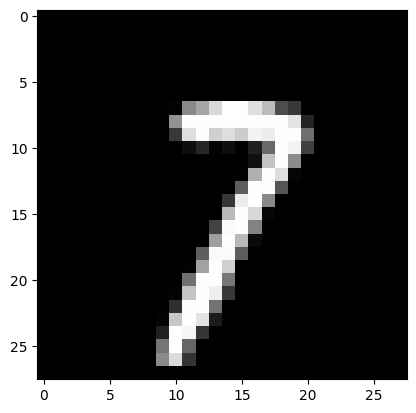

Label: 9


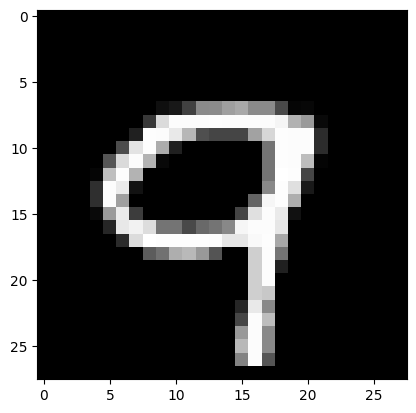

In [13]:
# Function to unnormalize and show an image
def show_image(img):
    img = img / 2 + 0.5  # Unnormalize
    np_img = img.numpy()
    plt.imshow(np_img.squeeze(), cmap="gray")
    plt.show()

# Print 2 random images from the dataset
for i in range(2):
    img, label = random.choice(trainset)  # Randomly select an image
    print(f'Label: {label}')
    show_image(img)

In [14]:
# Train the model
def train(model, trainloader, criterion, optimizer, device, epochs=20):
  model.train()
  for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in trainloader:
      images, labels = images.to(device), labels.to(device)

      # Zero the gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(images)
      loss = criterion(outputs, labels)

      # Backward pass and optimization
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(trainloader):.4f}")

In [15]:
# Test the model on the test set
def test(model, testloader, device):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in testloader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print(f"Test Accuracy: {100 * correct / total:.2f}%")

In [16]:
# Train and evaluate the model
train(model1, trainloader, criterion1, optimizer1, device, epochs=20)
test(model1, testloader, device)

train(model2, trainloader, criterion1, optimizer2, device, epochs=20)
test(model2, testloader, device)

Epoch [1/20], Loss: 0.2436
Epoch [2/20], Loss: 0.0696
Epoch [3/20], Loss: 0.0488
Epoch [4/20], Loss: 0.0372
Epoch [5/20], Loss: 0.0286
Epoch [6/20], Loss: 0.0250
Epoch [7/20], Loss: 0.0179
Epoch [8/20], Loss: 0.0158
Epoch [9/20], Loss: 0.0133
Epoch [10/20], Loss: 0.0132
Epoch [11/20], Loss: 0.0104
Epoch [12/20], Loss: 0.0083
Epoch [13/20], Loss: 0.0092
Epoch [14/20], Loss: 0.0076
Epoch [15/20], Loss: 0.0053
Epoch [16/20], Loss: 0.0062
Epoch [17/20], Loss: 0.0082
Epoch [18/20], Loss: 0.0063
Epoch [19/20], Loss: 0.0038
Epoch [20/20], Loss: 0.0053
Test Accuracy: 98.48%
Epoch [1/20], Loss: 0.2416
Epoch [2/20], Loss: 0.0723
Epoch [3/20], Loss: 0.0495
Epoch [4/20], Loss: 0.0410
Epoch [5/20], Loss: 0.0354
Epoch [6/20], Loss: 0.0282
Epoch [7/20], Loss: 0.0253
Epoch [8/20], Loss: 0.0199
Epoch [9/20], Loss: 0.0193
Epoch [10/20], Loss: 0.0179
Epoch [11/20], Loss: 0.0143
Epoch [12/20], Loss: 0.0146
Epoch [13/20], Loss: 0.0124
Epoch [14/20], Loss: 0.0114
Epoch [15/20], Loss: 0.0115
Epoch [16/20], L

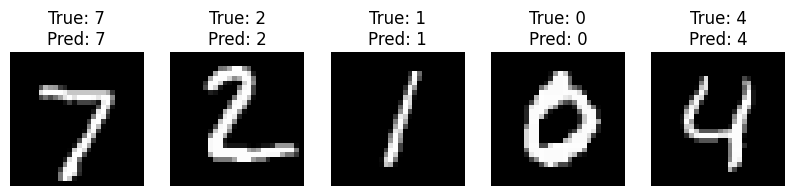

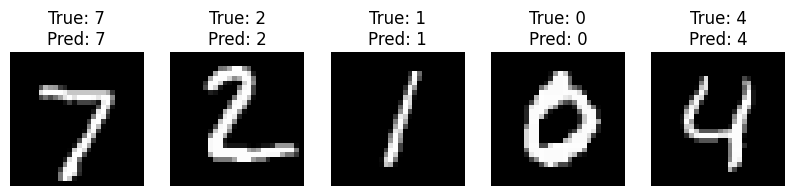

In [17]:
# Function to visualize predictions
def visualize_predictions(model, testloader, num_images=5):
    model.eval()  # Set model to evaluation mode

    # Get some random test images
    images, labels = next(iter(testloader))
    images, labels = images[:num_images], labels[:num_images]

    # Forward pass: Get predictions
    with torch.no_grad():
        outputs = model(images)

    _, predicted = torch.max(outputs, 1)

    # Plot the images and show true and predicted labels
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i in range(num_images):
        img = images[i].squeeze()  # Remove the extra channel dimension
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(f'True: {labels[i]}\nPred: {predicted[i]}')
        axes[i].axis('off')
    plt.show()

# Visualize predictions on 5 random test images
visualize_predictions(model1, testloader, num_images=5)
visualize_predictions(model2, testloader, num_images=5)